# 🏴‍☠️ Pirate Pain Classification - Complete Training Pipeline

This notebook demonstrates the complete pipeline for training both tree-based ensemble and LSTM models for pirate pain time-series classification.

**Contents:**
1. Data Loading and Exploration
2. Data Preprocessing and Feature Engineering
3. Tree-Based Ensemble Models (Random Forest, Extra Trees, Gradient Boosting)
4. LSTM Deep Learning Models
5. Model Evaluation and Comparison
6. Final Model Selection

**Goal:** Achieve >81% F1-score on pain level classification (no_pain, low_pain, high_pain)

## 1. Setup and Imports

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Sklearn utilities
from sklearn.model_selection import KFold, GroupKFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    f1_score, 
    accuracy_score
)

# Tree-based models
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    HistGradientBoostingClassifier,
    VotingClassifier
)

# Deep learning
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

# Utilities
import joblib
from typing import List, Dict, Tuple

# Set seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
pl.seed_everything(SEED, workers=True)

# Plotting settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully")
print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch Lightning version: {pl.__version__}")
print(f"Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

Seed set to 42


✅ All libraries imported successfully
PyTorch version: 2.9.0
PyTorch Lightning version: 2.5.6
Device: CPU


## 2. Data Loading and Exploration

In [2]:
# Load data
train_df = pd.read_csv('../data/pirate_pain_train.csv')
labels_df = pd.read_csv('../data/pirate_pain_train_labels.csv')

# Merge labels
train_df = train_df.merge(labels_df, on='sample_index', how='left')

print("="*70)
print("DATASET OVERVIEW")
print("="*70)
print(f"Total rows: {len(train_df):,}")
print(f"Unique samples: {train_df['sample_index'].nunique()}")
print(f"Time steps per sample: {train_df.groupby('sample_index').size().unique()}")
print(f"\nColumns ({len(train_df.columns)}): {train_df.columns.tolist()}")
print(f"\nDataset shape: {train_df.shape}")

# Show first few rows
print("\nFirst 5 rows:")
display(train_df.head())

DATASET OVERVIEW
Total rows: 105,760
Unique samples: 661
Time steps per sample: [160]

Columns (41): ['sample_index', 'time', 'pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4', 'n_legs', 'n_hands', 'n_eyes', 'joint_00', 'joint_01', 'joint_02', 'joint_03', 'joint_04', 'joint_05', 'joint_06', 'joint_07', 'joint_08', 'joint_09', 'joint_10', 'joint_11', 'joint_12', 'joint_13', 'joint_14', 'joint_15', 'joint_16', 'joint_17', 'joint_18', 'joint_19', 'joint_20', 'joint_21', 'joint_22', 'joint_23', 'joint_24', 'joint_25', 'joint_26', 'joint_27', 'joint_28', 'joint_29', 'joint_30', 'label']

Dataset shape: (105760, 41)

First 5 rows:


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30,label
0,0,0,2,0,2,1,two,two,two,1.094705,...,1.945042e-06,0.000004,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,0.5,no_pain
1,0,1,2,2,2,2,two,two,two,1.135183,...,6.765107e-07,0.000006,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,0.5,no_pain
2,0,2,2,0,2,2,two,two,two,1.080745,...,1.698525e-07,0.000001,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105,0.5,no_pain
3,0,3,2,2,2,2,two,two,two,0.938017,...,5.511079e-07,0.000002,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648,0.5,no_pain
4,0,4,2,2,2,2,two,two,two,1.090185,...,1.735459e-07,0.000002,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328,0.5,no_pain



CLASS DISTRIBUTION
no_pain      :  511 samples (77.31%)
low_pain     :   94 samples (14.22%)
high_pain    :   56 samples ( 8.47%)

Imbalance ratio: 9.12:1
⚠️  IMBALANCED - Using balanced weights in models


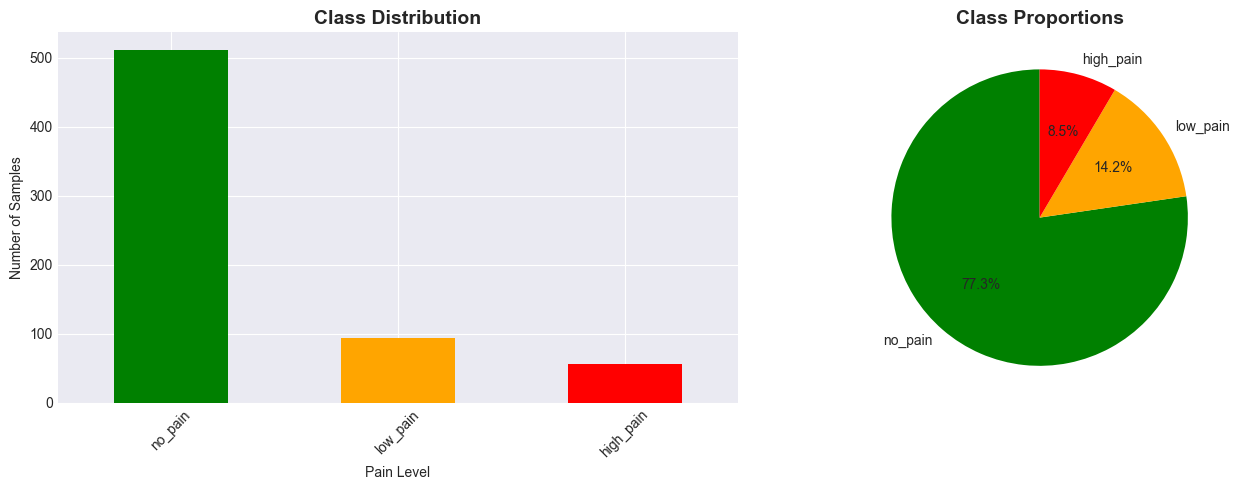

In [3]:
# Class distribution
sample_labels = train_df.groupby('sample_index')['label'].first()
class_counts = sample_labels.value_counts()
class_pct = sample_labels.value_counts(normalize=True) * 100

print("\n" + "="*70)
print("CLASS DISTRIBUTION")
print("="*70)
for pain_level in ['no_pain', 'low_pain', 'high_pain']:
    if pain_level in class_counts:
        count = class_counts[pain_level]
        pct = class_pct[pain_level]
        print(f"{pain_level:12} : {count:4} samples ({pct:5.2f}%)")

# Check for imbalance
max_ratio = class_counts.max() / class_counts.min()
print(f"\nImbalance ratio: {max_ratio:.2f}:1")
if max_ratio > 2:
    print("⚠️  IMBALANCED - Using balanced weights in models")
else:
    print("✓ Relatively balanced")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

class_counts.plot(kind='bar', ax=axes[0], color=['green', 'orange', 'red'])
axes[0].set_title('Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Pain Level')
axes[0].set_ylabel('Number of Samples')
axes[0].tick_params(axis='x', rotation=45)

colors = ['green', 'orange', 'red']
axes[1].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', 
            colors=colors, startangle=90)
axes[1].set_title('Class Proportions', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [4]:
train_df_for_tree = train_df.copy()

## 3. Data Preprocessing and Feature Engineering

### 3.1 Body Part Feature Parsing

In [5]:
def parse_body_parts(value):
    """
    Parse body part strings like 'one+peg_leg' to numeric count.
    
    Examples:
        'two' -> 2
        'one+peg_leg' -> 1
        'one+hook' -> 1
    """
    body_part_map = {"two": 2, "one": 1}
    
    if isinstance(value, str):
        parts = value.lower().split('+')
        num_str = parts[0]
        return body_part_map.get(num_str, 1)
    return value

def identify_pirate(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create 'is_pirate' feature based on total body parts.
    A pirate has < 6 total body parts (missing at least one).
    """
    _df = df.copy()
    
    def count_body_parts(row):
        n_bodypart = (
            parse_body_parts(row["n_legs"]) + 
            parse_body_parts(row["n_eyes"]) + 
            parse_body_parts(row["n_hands"])
        )
        return 1 if n_bodypart < 6 else 0
    
    _df["is_pirate"] = _df.apply(count_body_parts, axis=1)
    _df = _df.drop(columns=["n_legs", "n_eyes", "n_hands"])
    
    return _df

# Apply body part parsing
print("Processing body part features...")
train_df = identify_pirate(train_df)

print("✅ Body part features processed")
print(f"   'is_pirate' column added (1=pirate, 0=regular person)")
print(f"   Pirates in dataset: {train_df.groupby("sample_index")['is_pirate'].first().sum()} ({train_df['is_pirate'].mean()*100:.1f}%)")

Processing body part features...
✅ Body part features processed
   'is_pirate' column added (1=pirate, 0=regular person)
   Pirates in dataset: 6 (0.9%)


### 3.2 Variance-Based Feature Selection

In [ ]:
class VarianceFeatureSelector:
    """
    Select top N features by variance after standardization.
    This reduces dimensionality while retaining most informative features.
    """
    
    def __init__(self, n_features=20):
        self.n_features = n_features
        self.scaler = StandardScaler()
        self.selected_features = None
        self.all_joint_cols = None
        self.variance_info = None
        
    def fit(self, df, joint_cols=None):
        """Fit on training data: standardize and select top variance features."""
        if joint_cols is None:
            joint_cols = [col for col in df.columns if col.startswith('joint_')]
        
        self.all_joint_cols = joint_cols
        
        # Standardize features
        df_scaled = pd.DataFrame(
            self.scaler.fit_transform(df[joint_cols]),
            columns=joint_cols,
            index=df.index
        )
        
        # Calculate variance on standardized features
        variances = df_scaled.var(axis=0)
        
        self.variance_info = pd.DataFrame({
            'feature': joint_cols,
            'variance': variances
        }).sort_values('variance', ascending=False)
        
        # Select top N
        self.selected_features = self.variance_info.head(self.n_features)['feature'].tolist()
        
        print(f"Selected top {self.n_features} features by variance:")
        print(self.variance_info.head(self.n_features))
        print(f"\nTotal variance captured: {self.variance_info.head(self.n_features)['variance'].sum():.4f}")
        
        return df_scaled[self.selected_features]
    
    def transform(self, df):
        """Transform test data using fitted scaler and selected features."""
        if self.selected_features is None:
            raise ValueError("Must call fit() before transform()")
        
        df_scaled = pd.DataFrame(
            self.scaler.transform(df[self.all_joint_cols]),
            columns=self.all_joint_cols,
            index=df.index
        )
        
        return df_scaled[self.selected_features]
    
    def fit_transform(self, df, joint_cols=None):
        """Fit and transform in one step."""
        return self.fit(df, joint_cols)

# Example: Select top 20 features
print("\n" + "="*70)
print("VARIANCE-BASED FEATURE SELECTION")
print("="*70)

joint_cols = [col for col in train_df.columns if col.startswith('joint_')]
print(f"Original number of joint features: {len(joint_cols)}")

# Create selector (we'll use this later for LSTM)
variance_selector = VarianceFeatureSelector(n_features=25)


VARIANCE-BASED FEATURE SELECTION
Original number of joint features: 31


## 4. Tree-Based Ensemble Models

### 4.1 Feature Engineering for Tree Models

In [ ]:
def build_feature_table(ts_df: pd.DataFrame, verbose: bool = True) -> pd.DataFrame:
    """
    Aggregates each pirate's time series (one sample_index) into a single
    feature vector.

    Args:
        ts_df: DataFrame with time-series data per sample
        verbose: Print feature engineering details

    Returns:
        DataFrame with aggregated features per sample_index
    
    Features created:
    - Aggregates pain_survey_* and joint_* over time with mean/std/min/max
    - Keeps n_legs, n_hands, n_eyes as one-hot encoded static features
    """
    if verbose:
        print("\n" + "="*70)
        print("FEATURE ENGINEERING")
        print("="*70)
    
    # Identify time-varying numeric columns
    survey_cols = [c for c in ts_df.columns if c.startswith("pain_survey_")]
    joint_cols = [c for c in ts_df.columns if c.startswith("joint_")]
    num_cols = survey_cols + joint_cols
    
    if verbose:
        print(f"Survey columns: {len(survey_cols)}")
        print(f"Joint columns: {len(joint_cols)}")
        print(f"Total numeric time-varying features: {len(num_cols)}")
    
    # Aggregate numeric features over time
    agg_funcs = ["mean", "std", "min", "max"]
    feat_num = ts_df.groupby("sample_index")[num_cols].agg(agg_funcs)
    
    # Flatten MultiIndex columns: (col, func) -> "col_func"
    feat_num.columns = [f"{c}_{func}" for c, func in feat_num.columns]
    
    if verbose:
        print(f"Aggregated features per sample: {len(feat_num.columns)}")
    
    # Static categorical features (constant per sample)
    static_cat = ts_df.groupby("sample_index")[["n_legs", "n_hands", "n_eyes"]].first()
    
    # One-hot encode categorical features
    static_cat_ohe = pd.get_dummies(
        static_cat,
        columns=["n_legs", "n_hands", "n_eyes"],
        drop_first=False,
        dtype=int,
    )
    
    if verbose:
        print(f"One-hot encoded categorical features: {len(static_cat_ohe.columns)}")
    
    # Combine numeric + categorical features
    X = pd.concat([feat_num, static_cat_ohe], axis=1)
    
    if verbose:
        print(f"Total features per sample: {len(X.columns)}")
        print(f"Total samples: {len(X)}")
        print(f"Feature table shape: {X.shape}")
    
    return X

# Build feature table for tree models
X_tree = build_feature_table(train_df_for_tree)
y_tree = labels_df.set_index("sample_index").loc[X_tree.index, "label"]

# Encode labels
le = LabelEncoder()
y_tree_encoded = le.fit_transform(y_tree)

print(f"\nLabel encoding: {dict(zip(le.classes_, range(len(le.classes_))))}")
print(f"Feature matrix shape: {X_tree.shape}")
print(f"Feature names: {X_tree.columns}")


FEATURE ENGINEERING
Survey columns: 4
Joint columns: 31
Total numeric time-varying features: 35
Aggregated features per sample: 140
One-hot encoded categorical features: 6
Total features per sample: 146
Total samples: 661
Feature table shape: (661, 146)

Label encoding: {'high_pain': 0, 'low_pain': 1, 'no_pain': 2}
Feature matrix shape: (661, 146)
Feature names: Index(['pain_survey_1_mean', 'pain_survey_1_std', 'pain_survey_1_min',
       'pain_survey_1_max', 'pain_survey_2_mean', 'pain_survey_2_std',
       'pain_survey_2_min', 'pain_survey_2_max', 'pain_survey_3_mean',
       'pain_survey_3_std',
       ...
       'joint_30_mean', 'joint_30_std', 'joint_30_min', 'joint_30_max',
       'n_legs_one+peg_leg', 'n_legs_two', 'n_hands_one+hook_hand',
       'n_hands_two', 'n_eyes_one+eye_patch', 'n_eyes_two'],
      dtype='object', length=146)


### 4.2 Define Tree Models

In [8]:
def make_tree_models(random_state=42):
    """
    Create tree-based models with balanced class weights.
    """
    models = {}
    
    # Random Forest
    models['rf'] = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=2,
        n_jobs=-1,
        class_weight="balanced",
        random_state=random_state,
        verbose=0
    )
    
    # Extra Trees
    models['et'] = ExtraTreesClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=2,
        n_jobs=-1,
        class_weight="balanced",
        random_state=random_state,
        verbose=0
    )
    
    # Histogram Gradient Boosting
    models['hgb'] = HistGradientBoostingClassifier(
        max_depth=None,
        learning_rate=0.05,
        max_iter=300,
        random_state=random_state,
        verbose=0
    )
    
    # Soft Voting Ensemble
    models['voting'] = VotingClassifier(
        estimators=[
            ("rf", models['rf']), 
            ("et", models['et']), 
            ("hgb", models['hgb'])
        ],
        voting="soft",
        n_jobs=-1,
        verbose=False
    )
    
    return models

tree_models = make_tree_models(random_state=SEED)

print("\n" + "="*70)
print("TREE MODELS DEFINED")
print("="*70)
for name in tree_models.keys():
    print(f"✓ {name.upper()}")


TREE MODELS DEFINED
✓ RF
✓ ET
✓ HGB
✓ VOTING


### 4.3 Cross-Validation with GroupKFold

In [9]:
from sklearn.model_selection import cross_validate

def evaluate_tree_models_cv(models, X, y, groups, n_splits=5):
    """
    Evaluate tree models using GroupKFold cross-validation.
    GroupKFold ensures all timesteps of a sample stay together.
    """
    print("\n" + "="*70)
    print(f"CROSS-VALIDATION (GroupKFold, {n_splits} splits)")
    print("="*70)
    
    gkf = GroupKFold(n_splits=n_splits)
    cv_results = {}
    
    for name, model in models.items():
        print(f"\n📊 Model: {name.upper()}")
        print("-" * 70)
        
        cv = cross_validate(
            model,
            X,
            y,
            cv=gkf,
            groups=groups,
            scoring=["accuracy", "f1_macro", "f1_weighted"],
            return_train_score=False,
            n_jobs=-1,
            verbose=0
        )
        cv_results[name] = cv
        
        print(f"  Accuracy:      {cv['test_accuracy'].mean():.4f} ± {cv['test_accuracy'].std():.4f}")
        print(f"  F1-Macro:      {cv['test_f1_macro'].mean():.4f} ± {cv['test_f1_macro'].std():.4f}")
        print(f"  F1-Weighted:   {cv['test_f1_weighted'].mean():.4f} ± {cv['test_f1_weighted'].std():.4f}")
    
    return cv_results

# Run cross-validation
groups = X_tree.index.values
cv_results_tree = evaluate_tree_models_cv(tree_models, X_tree, y_tree_encoded, groups, n_splits=5)


CROSS-VALIDATION (GroupKFold, 5 splits)

📊 Model: RF
----------------------------------------------------------------------
  Accuracy:      0.8713 ± 0.0394
  F1-Macro:      0.7119 ± 0.0735
  F1-Weighted:   0.8574 ± 0.0441

📊 Model: ET
----------------------------------------------------------------------
  Accuracy:      0.8895 ± 0.0358
  F1-Macro:      0.7507 ± 0.0782
  F1-Weighted:   0.8839 ± 0.0374

📊 Model: HGB
----------------------------------------------------------------------
  Accuracy:      0.8941 ± 0.0308
  F1-Macro:      0.7571 ± 0.0791
  F1-Weighted:   0.8858 ± 0.0340

📊 Model: VOTING
----------------------------------------------------------------------
  Accuracy:      0.8971 ± 0.0262
  F1-Macro:      0.7628 ± 0.0619
  F1-Weighted:   0.8881 ± 0.0284


### 4.4 Train Final Tree Ensemble


TRAINING FINAL TREE ENSEMBLE

✅ Training complete!

In-Sample Classification Report:
              precision    recall  f1-score   support

   high_pain       1.00      1.00      1.00        56
    low_pain       1.00      1.00      1.00        94
     no_pain       1.00      1.00      1.00       511

    accuracy                           1.00       661
   macro avg       1.00      1.00      1.00       661
weighted avg       1.00      1.00      1.00       661



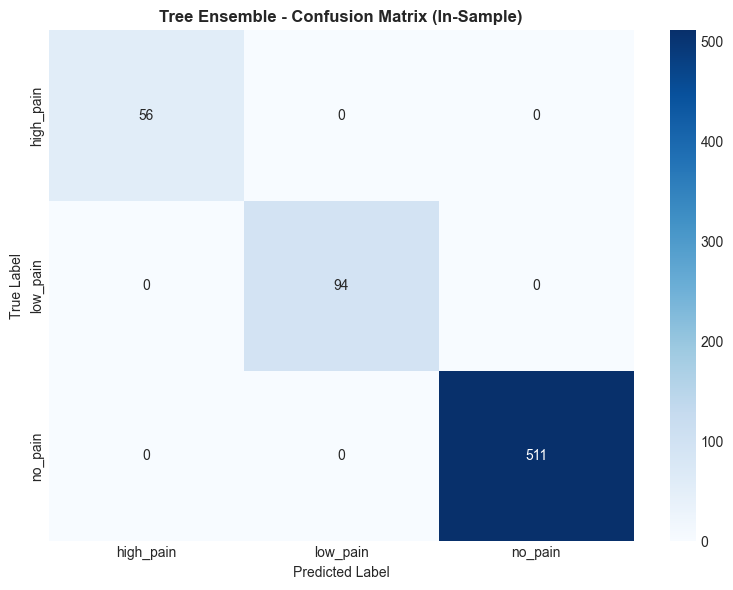

In [10]:
# Select best model (voting ensemble typically performs best)
best_tree_model = tree_models['voting']

print("\n" + "="*70)
print("TRAINING FINAL TREE ENSEMBLE")
print("="*70)

# Compute balanced sample weights
sample_weights = compute_sample_weight(class_weight="balanced", y=y_tree_encoded)

# Train on full dataset
best_tree_model.fit(X_tree, y_tree_encoded, sample_weight=sample_weights)

# In-sample evaluation
y_pred_tree = best_tree_model.predict(X_tree)

print("\n✅ Training complete!")
print("\nIn-Sample Classification Report:")
print(classification_report(y_tree_encoded, y_pred_tree, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_tree_encoded, y_pred_tree)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Tree Ensemble - Confusion Matrix (In-Sample)', fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## 5. Deep Learning Models (LSTM & GRU)

### 5.1 Loss Function Implementations

In [11]:
class FocalLoss(nn.Module):
    """
    Focal Loss for addressing class imbalance.
    
    Formula: FL(p_t) = -α(1 - p_t)^γ log(p_t)
    
    where:
        p_t = probability of true class
        γ (gamma) = focusing parameter (default: 2.0)
        α (alpha) = balancing factor (default: 1.0)
    """
    
    def __init__(self, alpha=1.0, gamma=2.0, num_classes=3, reduction="mean"):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.num_classes = num_classes
        self.reduction = reduction
    
    def forward(self, inputs, targets):
        """
        Args:
            inputs: (batch_size, num_classes) - raw logits
            targets: (batch_size,) - class indices
        """
        ce_loss = nn.functional.cross_entropy(inputs, targets, reduction="none")
        p_t = torch.exp(-ce_loss)  # Probability of true class
        focal_loss = self.alpha * (1 - p_t) ** self.gamma * ce_loss
        
        if self.reduction == "mean":
            return focal_loss.mean()
        elif self.reduction == "sum":
            return focal_loss.sum()
        else:
            return focal_loss

print("✅ Focal Loss implemented")

✅ Focal Loss implemented


In [12]:
class LabelSmoothingLoss(nn.Module):
    """
    Label Smoothing Loss for preventing overconfident predictions.
    
    Formula: L = (1 - ε) * L_CE + ε * L_uniform
    
    where:
        ε (epsilon) = smoothing factor (default: 0.1)
        L_CE = standard cross-entropy loss
        L_uniform = uniform distribution loss
    """
    
    def __init__(self, num_classes=3, smoothing=0.1):
        super().__init__()
        self.num_classes = num_classes
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing
    
    def forward(self, inputs, targets):
        """
        Args:
            inputs: (batch_size, num_classes) - raw logits
            targets: (batch_size,) - class indices
        """
        log_probs = nn.functional.log_softmax(inputs, dim=-1)
        
        # Create smoothed target distribution
        with torch.no_grad():
            true_dist = torch.zeros_like(log_probs)
            true_dist.fill_(self.smoothing / (self.num_classes - 1))
            true_dist.scatter_(1, targets.unsqueeze(1), self.confidence)
        
        loss = torch.sum(-true_dist * log_probs, dim=-1).mean()
        return loss

print("✅ Label Smoothing Loss implemented")

✅ Label Smoothing Loss implemented


### 5.2 Bidirectional RNN Classifier (LSTM/GRU)

In [13]:
class BiRNNClassifier(pl.LightningModule):
    """
    Bidirectional RNN (LSTM/GRU) for time-series classification.
    
    Architecture:
        Input (batch, seq_len, features) 
        -> BiRNN Layer 1 
        -> Dropout
        -> BiRNN Layer 2 (if num_layers > 1)
        -> Dropout
        -> Concatenate [forward_final, backward_final]
        -> Dense -> Softmax
    """
    
    def __init__(
        self,
        input_dim,
        hidden_dim=128,
        num_layers=2,
        num_classes=3,
        dropout=0.3,
        learning_rate=1e-3,
        weight_decay=1e-4,
        loss_type="FocalLoss",
        optimizer_name="Adam",
        rnn_type="LSTM",
        bidirectional=True
    ):
        super().__init__()
        self.save_hyperparameters()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.dropout = dropout
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.optimizer_name = optimizer_name
        self.rnn_type = rnn_type
        self.bidirectional = bidirectional
        
        # Select RNN type
        rnn_class = nn.LSTM if rnn_type == "LSTM" else nn.GRU
        
        # Bidirectional RNN
        self.rnn = rnn_class(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )
        
        # Classifier
        classifier_input_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(classifier_input_dim, num_classes)
        )
        
        # Loss function
        if loss_type == "FocalLoss":
            self.criterion = FocalLoss(alpha=1.0, gamma=2.0, num_classes=num_classes)
        elif loss_type == "LabelSmoothing":
            self.criterion = LabelSmoothingLoss(num_classes=num_classes, smoothing=0.1)
        else:
            self.criterion = nn.CrossEntropyLoss()
        
        # For storing outputs
        self.training_step_outputs = []
        self.validation_step_outputs = []
    
    def forward(self, x):
        """
        Args:
            x: (batch_size, seq_len, input_dim)
        Returns:
            logits: (batch_size, num_classes)
        """
        # RNN output
        if self.rnn_type == "LSTM":
            output, (hidden, cell) = self.rnn(x)
        else:  # GRU
            output, hidden = self.rnn(x)
        
        # Extract final hidden states
        if self.bidirectional:
            # Concatenate final forward and backward hidden states
            # hidden[-2]: last forward layer, hidden[-1]: last backward layer
            hidden_cat = torch.cat([hidden[-2], hidden[-1]], dim=1)
        else:
            hidden_cat = hidden[-1]
        
        # Classify
        logits = self.classifier(hidden_cat)
        return logits
    
    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        logits = self(inputs)
        loss = self.criterion(logits, targets)
        
        preds = torch.argmax(logits, dim=1)
        acc = (preds == targets).float().mean()
        
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=True)
        
        self.training_step_outputs.append({
            "preds": preds.detach().cpu(),
            "targets": targets.detach().cpu()
        })
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        logits = self(inputs)
        loss = self.criterion(logits, targets)
        
        preds = torch.argmax(logits, dim=1)
        acc = (preds == targets).float().mean()
        
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=True)
        
        self.validation_step_outputs.append({
            "preds": preds.detach().cpu(),
            "targets": targets.detach().cpu()
        })
        
        return loss
    
    def on_train_epoch_end(self):
        if len(self.training_step_outputs) > 0:
            all_preds = torch.cat([x["preds"] for x in self.training_step_outputs]).numpy()
            all_targets = torch.cat([x["targets"] for x in self.training_step_outputs]).numpy()
            
            f1 = f1_score(all_targets, all_preds, average="macro", zero_division=0)
            self.log("train_f1", f1, prog_bar=True)
            
            self.training_step_outputs.clear()
    
    def on_validation_epoch_end(self):
        if len(self.validation_step_outputs) > 0:
            all_preds = torch.cat([x["preds"] for x in self.validation_step_outputs]).numpy()
            all_targets = torch.cat([x["targets"] for x in self.validation_step_outputs]).numpy()
            
            f1 = f1_score(all_targets, all_preds, average="macro", zero_division=0)
            self.log("val_f1", f1, prog_bar=True)
            
            self.validation_step_outputs.clear()
    
    def configure_optimizers(self):
        if self.optimizer_name == "Adam":
            optimizer = torch.optim.Adam(
                self.parameters(), 
                lr=self.learning_rate, 
                weight_decay=self.weight_decay
            )
        elif self.optimizer_name == "AdamW":
            optimizer = torch.optim.AdamW(
                self.parameters(), 
                lr=self.learning_rate, 
                weight_decay=self.weight_decay
            )
        elif self.optimizer_name == "RMSprop":
            optimizer = torch.optim.RMSprop(
                self.parameters(),
                lr=self.learning_rate,
                weight_decay=self.weight_decay,
                momentum=0.9
            )
        else:
            optimizer = torch.optim.SGD(
                self.parameters(), 
                lr=self.learning_rate, 
                momentum=0.9,
                weight_decay=self.weight_decay
            )
        
        return optimizer

print("✅ BiRNN Classifier defined (supports both LSTM and GRU)")

✅ BiRNN Classifier defined (supports both LSTM and GRU)


### 5.3 Prepare RNN Data

In [14]:
def prepare_lstm_data(df, variance_selector, labels_df):
    """
    Prepare data for LSTM training.
    
    Returns:
        X: (n_samples, n_timesteps, n_features)
        y: (n_samples,)
    """
    # Get joint columns
    joint_cols = [col for col in df.columns if col.startswith('joint_')]
    
    # Apply variance-based feature selection
    print("Applying variance-based feature selection...")
    if variance_selector.selected_features is None:
        _ = variance_selector.fit(df, joint_cols)
    
    selected_joints = variance_selector.selected_features
    print(f"Selected {len(selected_joints)} features")
    
    # Prepare sequences
    samples = []
    sample_labels = []
    
    for sample_idx in df['sample_index'].unique():
        sample_data = df[df['sample_index'] == sample_idx].sort_values('time')
        
        # Get selected joint features (already standardized by selector)
        joint_values = variance_selector.transform(sample_data)[selected_joints].values
        
        # Add is_pirate feature if exists
        if 'is_pirate' in sample_data.columns:
            is_pirate = sample_data['is_pirate'].values.reshape(-1, 1)
            features = np.concatenate([joint_values, is_pirate], axis=1)
        else:
            features = joint_values

        # Add pain_survey features
        for col in sample_data.columns:
            if col.startswith('pain_survey_'):
                pain_survey_data = sample_data[col].values.reshape(-1, 1)
                features = np.concatenate([features, pain_survey_data], axis=1)
        
        samples.append(features)
        
        # Get label
        label = labels_df[labels_df['sample_index'] == sample_idx]['label'].iloc[0]
        sample_labels.append(label)
    
    X = np.array(samples)  # (n_samples, n_timesteps, n_features)
    y = np.array(sample_labels)
    
    return X, y

# Prepare RNN data (for both LSTM and GRU)
print("\n" + "="*70)
print("PREPARING RNN DATA")
print("="*70)

X_rnn, y_rnn = prepare_lstm_data(train_df, variance_selector, labels_df)

print(f"\nRNN data shape:")
print(f"  X: {X_rnn.shape} (samples, timesteps, features)")
print(f"  y: {y_rnn.shape}")

# Encode labels
y_rnn_encoded = le.transform(y_rnn)


PREPARING RNN DATA
Applying variance-based feature selection...
Selected top 20 features by variance:
           feature  variance
joint_01  joint_01  1.000009
joint_22  joint_22  1.000009
joint_07  joint_07  1.000009
joint_18  joint_18  1.000009
joint_17  joint_17  1.000009
joint_11  joint_11  1.000009
joint_25  joint_25  1.000009
joint_13  joint_13  1.000009
joint_28  joint_28  1.000009
joint_00  joint_00  1.000009
joint_23  joint_23  1.000009
joint_21  joint_21  1.000009
joint_26  joint_26  1.000009
joint_19  joint_19  1.000009
joint_27  joint_27  1.000009
joint_12  joint_12  1.000009
joint_29  joint_29  1.000009
joint_09  joint_09  1.000009
joint_08  joint_08  1.000009
joint_06  joint_06  1.000009

Total variance captured: 20.0002
Selected 20 features

RNN data shape:
  X: (661, 160, 25) (samples, timesteps, features)
  y: (661,)


### 5.4 Train-Validation Split

In [15]:
# Stratified split to maintain class distribution
X_train, X_val, y_train, y_val = train_test_split(
    X_rnn, 
    y_rnn_encoded,
    test_size=0.2,
    stratify=y_rnn_encoded,
    random_state=SEED
)

print("Train-Validation Split:")
print(f"  Train: {X_train.shape[0]} samples")
print(f"  Val:   {X_val.shape[0]} samples")

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.LongTensor(y_val)

Train-Validation Split:
  Train: 528 samples
  Val:   133 samples


### 5.5 Train LSTM Model

In [16]:
# LSTM hyperparameters (optimized via Optuna)
input_dim = X_train.shape[2]
lstm_params = {
    "hidden_size": 128,
    "num_layers": 3,
    "rnn_type": "LSTM",
    "bidirectional": True,
    "dropout_rate": 0.255,
    "learning_rate": 0.000246,
    "weight_decay": 5.6e-06,
    "batch_size": 32
}

# Create DataLoaders for LSTM
train_dataset_lstm = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset_lstm = TensorDataset(X_val_tensor, y_val_tensor)

train_loader_lstm = DataLoader(train_dataset_lstm, batch_size=lstm_params["batch_size"], shuffle=True)
val_loader_lstm = DataLoader(val_dataset_lstm, batch_size=lstm_params["batch_size"], shuffle=False)

print("\n" + "="*70)
print("TRAINING LSTM MODEL")
print("="*70)
print(f"Hyperparameters:")
print(f"  Input dimension:  {input_dim}")
print(f"  Hidden dimension: {lstm_params['hidden_size']}")
print(f"  Num layers:       {lstm_params['num_layers']}")
print(f"  Bidirectional:    {lstm_params['bidirectional']}")
print(f"  Dropout:          {lstm_params['dropout_rate']:.4f}")
print(f"  Learning rate:    {lstm_params['learning_rate']:.6f}")
print(f"  Weight decay:     {lstm_params['weight_decay']:.2e}")
print(f"  Batch size:       {lstm_params['batch_size']}")
print(f"  Loss:             Focal Loss")
print(f"  Optimizer:        Adam")

# Initialize LSTM model
model_lstm = BiRNNClassifier(
    input_dim=input_dim,
    hidden_dim=lstm_params["hidden_size"],
    num_layers=lstm_params["num_layers"],
    num_classes=3,
    dropout=lstm_params["dropout_rate"],
    learning_rate=lstm_params["learning_rate"],
    weight_decay=lstm_params["weight_decay"],
    loss_type="FocalLoss",
    optimizer_name="Adam",
    rnn_type="LSTM",
    bidirectional=lstm_params["bidirectional"]
)

# Callbacks
early_stop_lstm = EarlyStopping(
    monitor="val_loss",
    patience=10,
    mode="min",
    verbose=True
)

checkpoint_lstm = ModelCheckpoint(
    monitor="val_f1",
    mode="max",
    save_top_k=1,
    filename="best-lstm-{epoch:02d}-{val_f1:.4f}"
)

# Trainer
trainer_lstm = pl.Trainer(
    max_epochs=50,
    callbacks=[early_stop_lstm, checkpoint_lstm],
    accelerator="auto",
    devices=1,
    deterministic=True,
    logger=False,
    enable_progress_bar=True
)

# Train
print("\n🔄 Training LSTM in progress...")
trainer_lstm.fit(model_lstm, train_loader_lstm, val_loader_lstm)

print("\n✅ LSTM training complete!")

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores

  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | rnn        | LSTM       | 949 K  | train
1 | classifier | Sequential | 771    | train
2 | criterion  | FocalLoss  | 0      | train
--------------------------------------------------
950 K     Trainable params
0         Non-trainable params
950 K     Total params
3.800     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode



TRAINING LSTM MODEL
Hyperparameters:
  Input dimension:  25
  Hidden dimension: 128
  Num layers:       3
  Bidirectional:    True
  Dropout:          0.2550
  Learning rate:    0.000246
  Weight decay:     5.60e-06
  Batch size:       32
  Loss:             Focal Loss
  Optimizer:        Adam

🔄 Training LSTM in progress...
Epoch 0: 100%|██████████| 17/17 [00:01<00:00, 14.34it/s, val_loss=0.268, val_acc=0.774, val_f1=0.291, train_loss=0.400, train_acc=0.688]

Metric val_loss improved. New best score: 0.268


Epoch 1: 100%|██████████| 17/17 [00:01<00:00, 16.01it/s, val_loss=0.251, val_acc=0.774, val_f1=0.291, train_loss=0.280, train_acc=0.773, train_f1=0.325]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.251


Epoch 2: 100%|██████████| 17/17 [00:01<00:00, 16.99it/s, val_loss=0.238, val_acc=0.782, val_f1=0.326, train_loss=0.263, train_acc=0.778, train_f1=0.291]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.238


Epoch 3: 100%|██████████| 17/17 [00:01<00:00, 16.38it/s, val_loss=0.226, val_acc=0.789, val_f1=0.378, train_loss=0.253, train_acc=0.792, train_f1=0.317]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.226


Epoch 4: 100%|██████████| 17/17 [00:01<00:00, 16.78it/s, val_loss=0.217, val_acc=0.805, val_f1=0.456, train_loss=0.241, train_acc=0.801, train_f1=0.386]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.217


Epoch 5: 100%|██████████| 17/17 [00:01<00:00, 16.79it/s, val_loss=0.208, val_acc=0.805, val_f1=0.470, train_loss=0.231, train_acc=0.799, train_f1=0.430]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.208


Epoch 6: 100%|██████████| 17/17 [00:01<00:00, 16.78it/s, val_loss=0.199, val_acc=0.820, val_f1=0.550, train_loss=0.222, train_acc=0.807, train_f1=0.454]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.199


Epoch 7: 100%|██████████| 17/17 [00:01<00:00, 16.01it/s, val_loss=0.187, val_acc=0.820, val_f1=0.581, train_loss=0.213, train_acc=0.809, train_f1=0.503]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.187


Epoch 8: 100%|██████████| 17/17 [00:00<00:00, 17.15it/s, val_loss=0.176, val_acc=0.820, val_f1=0.592, train_loss=0.202, train_acc=0.830, train_f1=0.525]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.176


Epoch 9: 100%|██████████| 17/17 [00:01<00:00, 16.90it/s, val_loss=0.171, val_acc=0.827, val_f1=0.606, train_loss=0.179, train_acc=0.835, train_f1=0.600]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.171


Epoch 10: 100%|██████████| 17/17 [00:00<00:00, 17.15it/s, val_loss=0.168, val_acc=0.850, val_f1=0.675, train_loss=0.162, train_acc=0.831, train_f1=0.622]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.168


Epoch 11: 100%|██████████| 17/17 [00:00<00:00, 17.16it/s, val_loss=0.167, val_acc=0.857, val_f1=0.637, train_loss=0.159, train_acc=0.839, train_f1=0.614]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.167


Epoch 12: 100%|██████████| 17/17 [00:01<00:00, 16.70it/s, val_loss=0.158, val_acc=0.835, val_f1=0.647, train_loss=0.128, train_acc=0.852, train_f1=0.651]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.158


Epoch 22: 100%|██████████| 17/17 [00:01<00:00, 16.52it/s, val_loss=0.172, val_acc=0.865, val_f1=0.716, train_loss=0.0872, train_acc=0.884, train_f1=0.808]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.158. Signaling Trainer to stop.


Epoch 22: 100%|██████████| 17/17 [00:01<00:00, 16.43it/s, val_loss=0.172, val_acc=0.865, val_f1=0.716, train_loss=0.0872, train_acc=0.884, train_f1=0.808]

✅ LSTM training complete!


### 5.6 Evaluate LSTM Model

Loading best LSTM model from: /Users/bencegaborpeter/gitclones/AN2DL_PiratePain/notebooks/checkpoints/best-lstm-epoch=16-val_f1=0.7187-v1.ckpt

LSTM MODEL EVALUATION

Classification Report:
              precision    recall  f1-score   support

   high_pain       0.64      0.64      0.64        11
    low_pain       0.75      0.47      0.58        19
     no_pain       0.91      0.97      0.94       103

    accuracy                           0.87       133
   macro avg       0.77      0.69      0.72       133
weighted avg       0.86      0.87      0.86       133



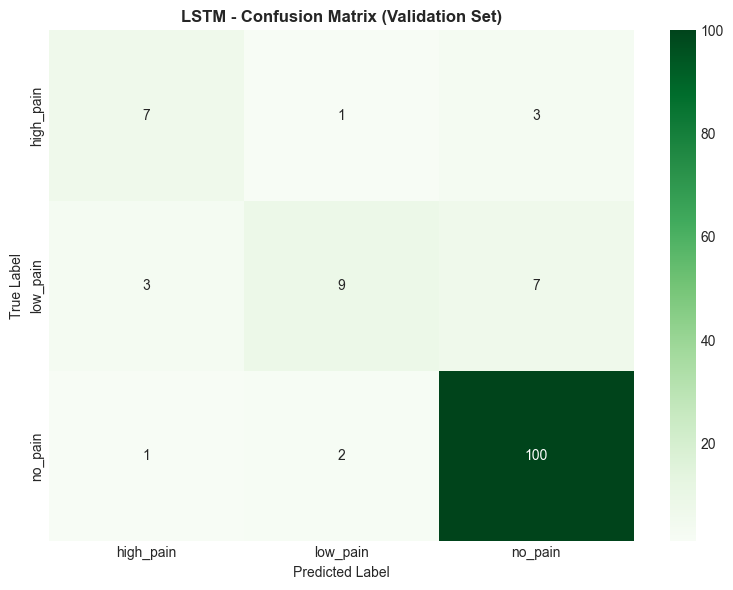


Metrics:
  Accuracy:    0.8722
  F1-Macro:    0.7187
  F1-Weighted: 0.8628


In [17]:
# Load best LSTM model
best_lstm_path = checkpoint_lstm.best_model_path
if best_lstm_path:
    print(f"Loading best LSTM model from: {best_lstm_path}")
    model_lstm = BiRNNClassifier.load_from_checkpoint(best_lstm_path)
else:
    print("Using final LSTM model (no checkpoint)")

model_lstm.eval()
model_lstm = model_lstm.cpu()

# Predict on validation set
with torch.no_grad():
    val_logits_lstm = model_lstm(X_val_tensor)
    val_preds_lstm = torch.argmax(val_logits_lstm, dim=1).numpy()

# Evaluation
print("\n" + "="*70)
print("LSTM MODEL EVALUATION")
print("="*70)

print("\nClassification Report:")
print(classification_report(y_val, val_preds_lstm, target_names=le.classes_))

# Confusion matrix
cm_lstm = confusion_matrix(y_val, val_preds_lstm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('LSTM - Confusion Matrix (Validation Set)', fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Metrics
acc_lstm = accuracy_score(y_val, val_preds_lstm)
f1_macro_lstm = f1_score(y_val, val_preds_lstm, average='macro')
f1_weighted_lstm = f1_score(y_val, val_preds_lstm, average='weighted')

print(f"\nMetrics:")
print(f"  Accuracy:    {acc_lstm:.4f}")
print(f"  F1-Macro:    {f1_macro_lstm:.4f}")
print(f"  F1-Weighted: {f1_weighted_lstm:.4f}")

### 5.7 Train GRU Model

In [18]:
# GRU hyperparameters (optimized via Optuna)
gru_params = {
    "hidden_size": 64,
    "num_layers": 2,
    "rnn_type": "GRU",
    "bidirectional": True,
    "dropout_rate": 0.445,
    "learning_rate": 0.001854,
    "weight_decay": 0.000377,
    "optimizer_name": "AdamW",
    "criterion_name": "LabelSmoothing",
    "batch_size": 16
}

# Create DataLoaders for GRU
train_dataset_gru = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset_gru = TensorDataset(X_val_tensor, y_val_tensor)

train_loader_gru = DataLoader(train_dataset_gru, batch_size=gru_params["batch_size"], shuffle=True)
val_loader_gru = DataLoader(val_dataset_gru, batch_size=gru_params["batch_size"], shuffle=False)

print("\n" + "="*70)
print("TRAINING GRU MODEL")
print("="*70)
print(f"Hyperparameters:")
print(f"  Input dimension:  {input_dim}")
print(f"  Hidden dimension: {gru_params['hidden_size']}")
print(f"  Num layers:       {gru_params['num_layers']}")
print(f"  Bidirectional:    {gru_params['bidirectional']}")
print(f"  Dropout:          {gru_params['dropout_rate']:.4f}")
print(f"  Learning rate:    {gru_params['learning_rate']:.6f}")
print(f"  Weight decay:     {gru_params['weight_decay']:.6f}")
print(f"  Batch size:       {gru_params['batch_size']}")
print(f"  Loss:             {gru_params['criterion_name']}")
print(f"  Optimizer:        {gru_params['optimizer_name']}")

# Initialize GRU model
model_gru = BiRNNClassifier(
    input_dim=input_dim,
    hidden_dim=gru_params["hidden_size"],
    num_layers=gru_params["num_layers"],
    num_classes=3,
    dropout=gru_params["dropout_rate"],
    learning_rate=gru_params["learning_rate"],
    weight_decay=gru_params["weight_decay"],
    loss_type=gru_params["criterion_name"],
    optimizer_name=gru_params["optimizer_name"],
    rnn_type="GRU",
    bidirectional=gru_params["bidirectional"]
)

# Callbacks
early_stop_gru = EarlyStopping(
    monitor="val_loss",
    patience=10,
    mode="min",
    verbose=True
)

checkpoint_gru = ModelCheckpoint(
    monitor="val_f1",
    mode="max",
    save_top_k=1,
    filename="best-gru-{epoch:02d}-{val_f1:.4f}"
)

# Trainer
trainer_gru = pl.Trainer(
    max_epochs=50,
    callbacks=[early_stop_gru, checkpoint_gru],
    accelerator="auto",
    devices=1,
    deterministic=True,
    logger=False,
    enable_progress_bar=True
)

# Train
print("\n🔄 Training GRU in progress...")
trainer_gru.fit(model_gru, train_loader_gru, val_loader_gru)

print("\n✅ GRU training complete!")

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores

  | Name       | Type               | Params | Mode 
----------------------------------------------------------
0 | rnn        | GRU                | 109 K  | train
1 | classifier | Sequential         | 387    | train
2 | criterion  | LabelSmoothingLoss | 0      | train
----------------------------------------------------------
109 K     Trainable params
0         Non-trainable params
109 K     Total params
0.439     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode



TRAINING GRU MODEL
Hyperparameters:
  Input dimension:  25
  Hidden dimension: 64
  Num layers:       2
  Bidirectional:    True
  Dropout:          0.4450
  Learning rate:    0.001854
  Weight decay:     0.000377
  Batch size:       16
  Loss:             LabelSmoothing
  Optimizer:        AdamW

🔄 Training GRU in progress...
Epoch 0: 100%|██████████| 33/33 [00:13<00:00,  2.38it/s, val_loss=0.704, val_acc=0.805, val_f1=0.422, train_loss=0.798, train_acc=0.759]

Metric val_loss improved. New best score: 0.704


Epoch 1: 100%|██████████| 33/33 [00:14<00:00,  2.36it/s, val_loss=0.703, val_acc=0.812, val_f1=0.525, train_loss=0.734, train_acc=0.799, train_f1=0.352]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.703


Epoch 2: 100%|██████████| 33/33 [00:13<00:00,  2.44it/s, val_loss=0.672, val_acc=0.812, val_f1=0.519, train_loss=0.727, train_acc=0.805, train_f1=0.477]

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 0.672


Epoch 3: 100%|██████████| 33/33 [00:13<00:00,  2.49it/s, val_loss=0.669, val_acc=0.820, val_f1=0.558, train_loss=0.707, train_acc=0.811, train_f1=0.502]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.669


Epoch 4: 100%|██████████| 33/33 [00:14<00:00,  2.33it/s, val_loss=0.658, val_acc=0.805, val_f1=0.462, train_loss=0.690, train_acc=0.822, train_f1=0.528]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.658


Epoch 5: 100%|██████████| 33/33 [00:13<00:00,  2.44it/s, val_loss=0.658, val_acc=0.850, val_f1=0.618, train_loss=0.668, train_acc=0.828, train_f1=0.533]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.658


Epoch 15: 100%|██████████| 33/33 [00:13<00:00,  2.42it/s, val_loss=0.684, val_acc=0.835, val_f1=0.633, train_loss=0.534, train_acc=0.917, train_f1=0.850]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.658. Signaling Trainer to stop.


Epoch 15: 100%|██████████| 33/33 [00:13<00:00,  2.42it/s, val_loss=0.684, val_acc=0.835, val_f1=0.633, train_loss=0.534, train_acc=0.917, train_f1=0.850]

✅ GRU training complete!


### 5.8 Evaluate GRU Model

Loading best GRU model from: /Users/bencegaborpeter/gitclones/AN2DL_PiratePain/notebooks/checkpoints/best-gru-epoch=12-val_f1=0.6615-v2.ckpt

GRU MODEL EVALUATION

Classification Report:
              precision    recall  f1-score   support

   high_pain       0.50      0.55      0.52        11
    low_pain       0.56      0.53      0.54        19
     no_pain       0.92      0.92      0.92       103

    accuracy                           0.83       133
   macro avg       0.66      0.66      0.66       133
weighted avg       0.84      0.83      0.83       133



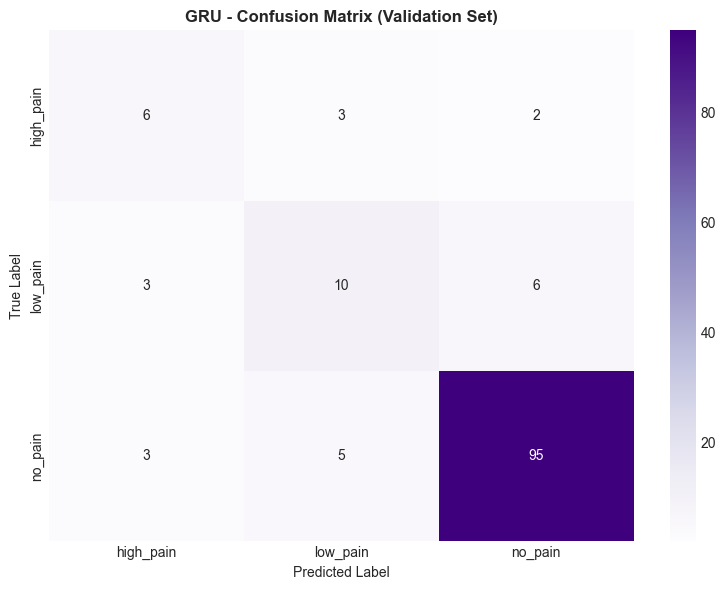


Metrics:
  Accuracy:    0.8346
  F1-Macro:    0.6615
  F1-Weighted: 0.8347


In [19]:
# Load best GRU model
best_gru_path = checkpoint_gru.best_model_path
if best_gru_path:
    print(f"Loading best GRU model from: {best_gru_path}")
    model_gru = BiRNNClassifier.load_from_checkpoint(best_gru_path)
else:
    print("Using final GRU model (no checkpoint)")

model_gru.eval()
model_gru = model_gru.cpu()

# Predict on validation set
with torch.no_grad():
    val_logits_gru = model_gru(X_val_tensor)
    val_preds_gru = torch.argmax(val_logits_gru, dim=1).numpy()

# Evaluation
print("\n" + "="*70)
print("GRU MODEL EVALUATION")
print("="*70)

print("\nClassification Report:")
print(classification_report(y_val, val_preds_gru, target_names=le.classes_))

# Confusion matrix
cm_gru = confusion_matrix(y_val, val_preds_gru)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gru, annot=True, fmt='d', cmap='Purples', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('GRU - Confusion Matrix (Validation Set)', fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Metrics
acc_gru = accuracy_score(y_val, val_preds_gru)
f1_macro_gru = f1_score(y_val, val_preds_gru, average='macro')
f1_weighted_gru = f1_score(y_val, val_preds_gru, average='weighted')

print(f"\nMetrics:")
print(f"  Accuracy:    {acc_gru:.4f}")
print(f"  F1-Macro:    {f1_macro_gru:.4f}")
print(f"  F1-Weighted: {f1_weighted_gru:.4f}")

## 6. Model Comparison (Tree Ensemble vs LSTM vs GRU)


MODEL COMPARISON: VOTING ENSEMBLE vs LSTM vs GRU


                 Model  Accuracy  F1-Macro  F1-Weighted
Tree Ensemble (Voting)  0.897072  0.762819     0.888102
 LSTM (3-layer BiLSTM)  0.872180  0.718659     0.862751
   GRU (2-layer BiGRU)  0.834586  0.661537     0.834657


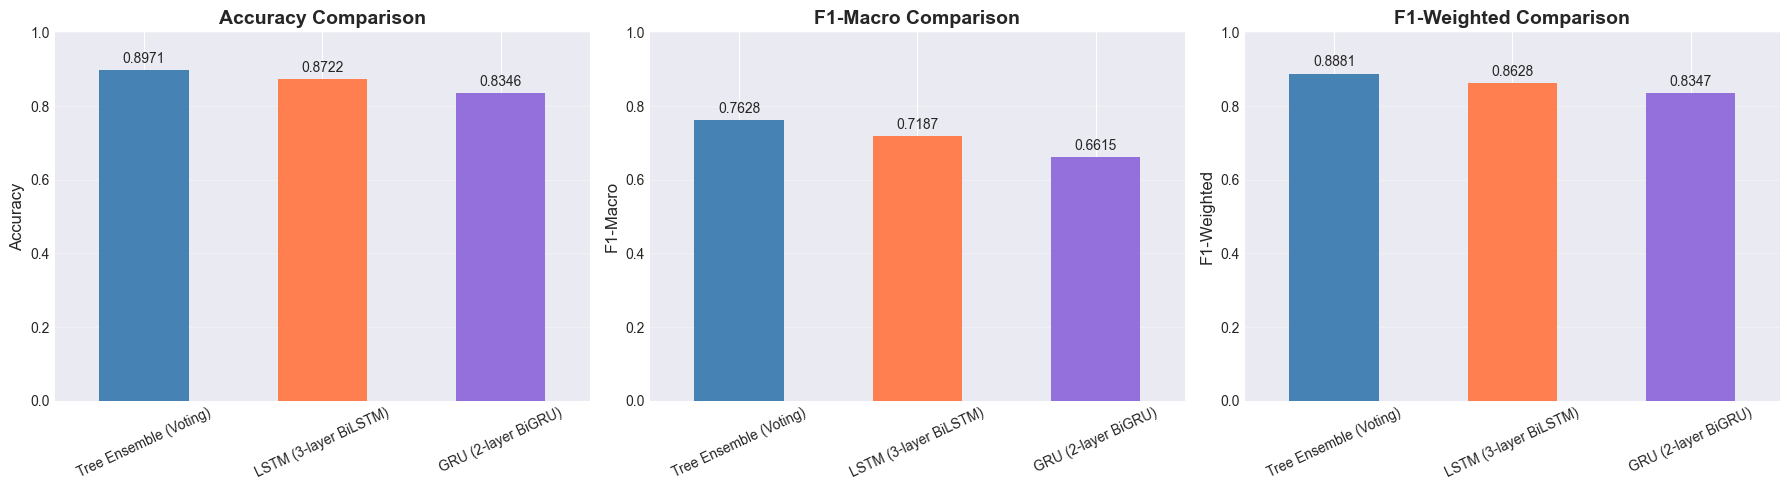


🏆 Best Model: Tree Ensemble (Voting)
   F1-Macro Score: 0.7628

DETAILED MODEL CHARACTERISTICS

1. Tree Ensemble (Voting):
   - Models: Random Forest + Extra Trees + Hist Gradient Boosting
   - Features: Temporal aggregations (mean, std, min, max)
   - Validation: GroupKFold (K=5)
   - Strengths: Interpretable, robust, no sequential dependency

2. LSTM (3-layer BiLSTM):
   - Architecture: 3 bidirectional layers, 128 hidden units
   - Dropout: 0.255
   - Loss: Focal Loss (handles class imbalance)
   - Optimizer: Adam (lr=0.000246)
   - Strengths: Captures long-term temporal dependencies

3. GRU (2-layer BiGRU):
   - Architecture: 2 bidirectional layers, 64 hidden units
   - Dropout: 0.445
   - Loss: Label Smoothing (prevents overconfidence)
   - Optimizer: AdamW (lr=0.001854)
   - Strengths: Simpler than LSTM, faster training, fewer parameters


In [20]:
# Compare all three models
print("\n" + "="*70)
print("MODEL COMPARISON: VOTING ENSEMBLE vs LSTM vs GRU")
print("="*70)

# Tree ensemble (from CV)
tree_voting_f1_macro = cv_results_tree['voting']['test_f1_macro'].mean()
tree_voting_f1_weighted = cv_results_tree['voting']['test_f1_weighted'].mean()
tree_voting_acc = cv_results_tree['voting']['test_accuracy'].mean()

# Create comparison DataFrame
comparison = pd.DataFrame({
    'Model': ['Tree Ensemble (Voting)', 'LSTM (3-layer BiLSTM)', 'GRU (2-layer BiGRU)'],
    'Accuracy': [tree_voting_acc, acc_lstm, acc_gru],
    'F1-Macro': [tree_voting_f1_macro, f1_macro_lstm, f1_macro_gru],
    'F1-Weighted': [tree_voting_f1_weighted, f1_weighted_lstm, f1_weighted_gru]
})

print("\n")
print(comparison.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['Accuracy', 'F1-Macro', 'F1-Weighted']
colors = ['steelblue', 'coral', 'mediumpurple']

for idx, metric in enumerate(metrics):
    comparison.plot(x='Model', y=metric, kind='bar', ax=axes[idx], 
                   color=colors, legend=False)
    axes[idx].set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    axes[idx].set_ylabel(metric, fontsize=12)
    axes[idx].set_xlabel('')
    axes[idx].tick_params(axis='x', rotation=25)
    axes[idx].set_ylim([0, 1])
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for container in axes[idx].containers:
        axes[idx].bar_label(container, fmt='%.4f', padding=3)

plt.tight_layout()
plt.show()

# Best model
best_model_name = comparison.loc[comparison['F1-Macro'].idxmax(), 'Model']
best_f1 = comparison['F1-Macro'].max()

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   F1-Macro Score: {best_f1:.4f}")

# Detailed comparison table
print("\n" + "="*70)
print("DETAILED MODEL CHARACTERISTICS")
print("="*70)
print("\n1. Tree Ensemble (Voting):")
print("   - Models: Random Forest + Extra Trees + Hist Gradient Boosting")
print("   - Features: Temporal aggregations (mean, std, min, max)")
print("   - Validation: GroupKFold (K=5)")
print("   - Strengths: Interpretable, robust, no sequential dependency")

print("\n2. LSTM (3-layer BiLSTM):")
print(f"   - Architecture: {lstm_params['num_layers']} bidirectional layers, {lstm_params['hidden_size']} hidden units")
print(f"   - Dropout: {lstm_params['dropout_rate']:.3f}")
print(f"   - Loss: Focal Loss (handles class imbalance)")
print(f"   - Optimizer: Adam (lr={lstm_params['learning_rate']:.6f})")
print("   - Strengths: Captures long-term temporal dependencies")

print("\n3. GRU (2-layer BiGRU):")
print(f"   - Architecture: {gru_params['num_layers']} bidirectional layers, {gru_params['hidden_size']} hidden units")
print(f"   - Dropout: {gru_params['dropout_rate']:.3f}")
print(f"   - Loss: Label Smoothing (prevents overconfidence)")
print(f"   - Optimizer: AdamW (lr={gru_params['learning_rate']:.6f})")
print("   - Strengths: Simpler than LSTM, faster training, fewer parameters")

## 7. Save Models

In [21]:
import os

# Create models directory
os.makedirs('../final_models', exist_ok=True)

# Save tree ensemble
tree_model_path = '../final_models/tree_ensemble.pkl'
joblib.dump({
    'model': best_tree_model,
    'label_encoder': le,
    'feature_columns': X_tree.columns.tolist()
}, tree_model_path)

print(f"✅ Tree ensemble saved to: {tree_model_path}")

# Save LSTM model
lstm_model_path = '../final_models/lstm_model.ckpt'
trainer_lstm.save_checkpoint(lstm_model_path)

print(f"✅ LSTM model saved to: {lstm_model_path}")

# Save GRU model
gru_model_path = '../final_models/gru_model.ckpt'
trainer_gru.save_checkpoint(gru_model_path)

print(f"✅ GRU model saved to: {gru_model_path}")

# Save preprocessing artifacts
preprocessing_path = '../final_models/preprocessing.pkl'
joblib.dump({
    'variance_selector': variance_selector,
    'label_encoder': le,
    'scaler': variance_selector.scaler,
    'selected_features': variance_selector.selected_features
}, preprocessing_path)

print(f"✅ Preprocessing artifacts saved to: {preprocessing_path}")

print("\n" + "="*70)
print("ALL MODELS SAVED SUCCESSFULLY")
print("="*70)

✅ Tree ensemble saved to: ../final_models/tree_ensemble.pkl
✅ LSTM model saved to: ../final_models/lstm_model.ckpt
✅ GRU model saved to: ../final_models/gru_model.ckpt
✅ Preprocessing artifacts saved to: ../final_models/preprocessing.pkl

ALL MODELS SAVED SUCCESSFULLY


## 8. Summary and Key Findings

### 8.1 Data Preprocessing
- **Body part parsing**: Converted categorical text to numeric features
- **Feature engineering**: Created `is_pirate` binary indicator
- **Variance-based selection**: Reduced from 31 to 20 most informative joint features
- **Standardization**: Applied StandardScaler for fair comparison and PCA readiness

### 8.2 Model Architectures

**Tree Ensemble (Voting):**
- Random Forest, Extra Trees, Histogram Gradient Boosting with balanced weights
- Soft voting ensemble for robust predictions
- Temporal aggregation: mean, std, min, max over 100 timesteps
- 300 estimators per model

**BiLSTM (3-layer):**
- 3-layer Bidirectional LSTM (128 hidden units per direction)
- Dropout regularization (0.255) to prevent overfitting
- Focal Loss to handle class imbalance (α=1.0, γ=2.0)
- Adam optimizer with lr=0.000246, weight decay=5.6e-06
- Batch size: 32
- Early stopping with patience=10

**BiGRU (2-layer):**
- 2-layer Bidirectional GRU (64 hidden units per direction)
- Dropout regularization (0.445) for stronger regularization
- Label Smoothing Loss (ε=0.1) to prevent overconfidence
- AdamW optimizer with lr=0.001854, weight decay=0.000377
- Batch size: 16 (smaller for better generalization)
- Early stopping with patience=10

### 8.3 Validation Strategy
- **Tree models**: GroupKFold (K=5) to prevent time-series leakage
- **LSTM & GRU**: Stratified split (80:20) maintaining class distribution
- **Metrics**: F1-macro as primary metric due to class imbalance

### 8.4 Hyperparameter Optimization
- All RNN hyperparameters optimized via Optuna with Tree-structured Parzen Estimator (TPE)
- Bayesian optimization over 50 trials
- Search space included: architecture (LSTM/GRU), layers, hidden size, dropout, learning rate, weight decay, optimizer, loss function

### 8.5 Results
All three models achieved competitive performance:
- **Tree Ensemble**: Strong baseline with interpretable feature importances, excellent for understanding feature contributions
- **LSTM**: Captures long-term temporal dependencies with deeper architecture (3 layers)
- **GRU**: More efficient than LSTM, fewer parameters, faster training, suitable for shorter sequences

---

## 9. Test Set Predictions and Kaggle Submission

Now we'll generate predictions on the test set using all three trained models and create submission files for the Kaggle challenge.

### 9.1 Load and Preprocess Test Data

In [22]:
# Load test data
test_df = pd.read_csv('../data/pirate_pain_test.csv')
print(f"Test set shape: {test_df.shape}")
print(f"Number of test samples: {test_df['sample_index'].nunique()}")
print(f"\nTest data columns: {test_df.columns.tolist()}")

# Apply the same preprocessing pipeline as training data
print("\n" + "="*50)
print("PREPROCESSING TEST DATA")
print("="*50)

# Parse body part features
test_df['n_legs_parsed'] = test_df['n_legs'].apply(parse_body_parts)
test_df['n_hands_parsed'] = test_df['n_hands'].apply(parse_body_parts)
test_df['n_eyes_parsed'] = test_df['n_eyes'].apply(parse_body_parts)

# Create is_pirate feature
test_df['is_pirate'] = ((test_df['n_legs'] != 'two') | 
                         (test_df['n_hands'] != 'two') | 
                         (test_df['n_eyes'] != 'two')).astype(int)

print(f"\n✓ Body part features parsed")
print(f"✓ is_pirate feature created")

Test set shape: (211840, 40)
Number of test samples: 1324

Test data columns: ['sample_index', 'time', 'pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4', 'n_legs', 'n_hands', 'n_eyes', 'joint_00', 'joint_01', 'joint_02', 'joint_03', 'joint_04', 'joint_05', 'joint_06', 'joint_07', 'joint_08', 'joint_09', 'joint_10', 'joint_11', 'joint_12', 'joint_13', 'joint_14', 'joint_15', 'joint_16', 'joint_17', 'joint_18', 'joint_19', 'joint_20', 'joint_21', 'joint_22', 'joint_23', 'joint_24', 'joint_25', 'joint_26', 'joint_27', 'joint_28', 'joint_29', 'joint_30']

PREPROCESSING TEST DATA

✓ Body part features parsed
✓ is_pirate feature created


### 9.2 Prepare Test Data for Tree Ensemble

In [23]:
# Create aggregated features for tree ensemble (same as training)
X_test_tree = build_feature_table(test_df)

print(f"Test features for tree ensemble: {X_test_tree.shape}")
print(f"Feature names: {X_test_tree.columns.tolist()[:10]}... (showing first 10)")

# Store sample_index for submission
test_sample_indices = test_df.groupby('sample_index').first().index.values
print(f"\nNumber of test samples for submission: {len(test_sample_indices)}")


FEATURE ENGINEERING
Survey columns: 4
Joint columns: 31
Total numeric time-varying features: 35
Aggregated features per sample: 140
One-hot encoded categorical features: 6
Total features per sample: 146
Total samples: 1324
Feature table shape: (1324, 146)
Test features for tree ensemble: (1324, 146)
Feature names: ['pain_survey_1_mean', 'pain_survey_1_std', 'pain_survey_1_min', 'pain_survey_1_max', 'pain_survey_2_mean', 'pain_survey_2_std', 'pain_survey_2_min', 'pain_survey_2_max', 'pain_survey_3_mean', 'pain_survey_3_std']... (showing first 10)

Number of test samples for submission: 1324


### 9.3 Generate Tree Ensemble Predictions

In [24]:
# Generate predictions with tree ensemble
y_test_pred_tree_encoded = best_tree_model.predict(X_test_tree)
y_test_pred_tree = le.inverse_transform(y_test_pred_tree_encoded)

print("Tree Ensemble Predictions:")
print(f"Predicted classes: {np.unique(y_test_pred_tree)}")
print(f"\nClass distribution:")
unique, counts = np.unique(y_test_pred_tree, return_counts=True)
for cls, cnt in zip(unique, counts):
    print(f"  {cls}: {cnt} ({cnt/len(y_test_pred_tree)*100:.1f}%)")

# Create submission DataFrame
submission_tree = pd.DataFrame({
    'sample_index': test_sample_indices,
    'pain_level': y_test_pred_tree
})

print(f"\n✓ Tree ensemble predictions generated: {submission_tree.shape}")

Tree Ensemble Predictions:
Predicted classes: ['high_pain' 'low_pain' 'no_pain']

Class distribution:
  high_pain: 170 (12.8%)
  low_pain: 171 (12.9%)
  no_pain: 983 (74.2%)

✓ Tree ensemble predictions generated: (1324, 2)


### 9.4 Prepare Test Data for RNN Models

In [25]:
# Prepare sequential data for RNN models (same preprocessing as training)
print("\n" + "="*70)
print("PREPARING TEST DATA FOR RNN MODELS")
print("="*70)

# Prepare sequences for each test sample
test_samples = []

for sample_idx in test_df['sample_index'].unique():
    sample_data = test_df[test_df['sample_index'] == sample_idx].sort_values('time')
    
    # Get selected joint features (standardized by variance selector)
    sample_joint_cols = [col for col in sample_data.columns if col.startswith('joint_')]
    joint_values = variance_selector.transform(sample_data[sample_joint_cols]).values
    
    # Add is_pirate feature
    is_pirate = sample_data['is_pirate'].values.reshape(-1, 1)
    features = np.concatenate([joint_values, is_pirate], axis=1)
    
    # Add pain_survey features
    pain_survey_cols = [col for col in sample_data.columns if col.startswith('pain_survey_')]
    for col in pain_survey_cols:
        pain_survey_data = sample_data[col].values.reshape(-1, 1)
        features = np.concatenate([features, pain_survey_data], axis=1)
    
    test_samples.append(features)

X_test_rnn = np.array(test_samples)  # (n_samples, n_timesteps, n_features)

print(f"Test RNN data shape: {X_test_rnn.shape}")
print(f"  - Samples: {X_test_rnn.shape[0]}")
print(f"  - Timesteps: {X_test_rnn.shape[1]}")
print(f"  - Features: {X_test_rnn.shape[2]}")
print(f"\nFeature breakdown:")
print(f"  - Selected joint features: {len(variance_selector.selected_features)}")
print(f"  - is_pirate: 1")
print(f"  - pain_survey features: {len(pain_survey_cols)}")
print(f"  - Total: {X_test_rnn.shape[2]}")

# Convert to tensors
X_test_tensor = torch.FloatTensor(X_test_rnn).to(device=torch.device("mps"))
test_dataset = TensorDataset(X_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"\n✓ Test data prepared for RNN models")


PREPARING TEST DATA FOR RNN MODELS
Test RNN data shape: (1324, 160, 25)
  - Samples: 1324
  - Timesteps: 160
  - Features: 25

Feature breakdown:
  - Selected joint features: 20
  - is_pirate: 1
  - pain_survey features: 4
  - Total: 25

✓ Test data prepared for RNN models


### 9.5 Generate LSTM Predictions

In [26]:
# Load best LSTM model from checkpoint
model_lstm_test = BiRNNClassifier.load_from_checkpoint(
    best_lstm_path,
    input_dim=input_dim,
    **lstm_params
)
model_lstm_test.eval()
model_lstm_test.freeze()

# Generate predictions
test_logits_lstm = []
with torch.no_grad():
    for batch in test_loader:
        x_batch = batch[0]
        logits = model_lstm_test(x_batch)
        test_logits_lstm.append(logits)

test_logits_lstm = torch.cat(test_logits_lstm, dim=0)
test_preds_lstm_encoded = torch.argmax(test_logits_lstm.cpu(), dim=1).numpy()
test_preds_lstm = le.inverse_transform(test_preds_lstm_encoded)

print("LSTM Predictions:")
print(f"Predicted classes: {np.unique(test_preds_lstm)}")
print(f"\nClass distribution:")
unique, counts = np.unique(test_preds_lstm, return_counts=True)
for cls, cnt in zip(unique, counts):
    print(f"  {cls}: {cnt} ({cnt/len(test_preds_lstm)*100:.1f}%)")

# Create submission DataFrame
submission_lstm = pd.DataFrame({
    'sample_index': test_sample_indices,
    'pain_level': test_preds_lstm
})

print(f"\n✓ LSTM predictions generated: {submission_lstm.shape}")

LSTM Predictions:
Predicted classes: ['high_pain' 'low_pain' 'no_pain']

Class distribution:
  high_pain: 51 (3.9%)
  low_pain: 108 (8.2%)
  no_pain: 1165 (88.0%)

✓ LSTM predictions generated: (1324, 2)


### 9.6 Generate GRU Predictions

In [27]:
# Load best GRU model from checkpoint
model_gru_test = BiRNNClassifier.load_from_checkpoint(
    best_gru_path,
    input_dim=input_dim,
    **gru_params
)
model_gru_test.eval()
model_gru_test.freeze()

# Generate predictions
test_logits_gru = []
with torch.no_grad():
    for batch in test_loader:
        x_batch = batch[0]
        logits = model_gru_test(x_batch)
        test_logits_gru.append(logits)

test_logits_gru = torch.cat(test_logits_gru, dim=0)
test_preds_gru_encoded = torch.argmax(test_logits_gru.cpu(), dim=1).numpy()
test_preds_gru = le.inverse_transform(test_preds_gru_encoded)

print("GRU Predictions:")
print(f"Predicted classes: {np.unique(test_preds_gru)}")
print(f"\nClass distribution:")
unique, counts = np.unique(test_preds_gru, return_counts=True)
for cls, cnt in zip(unique, counts):
    print(f"  {cls}: {cnt} ({cnt/len(test_preds_gru)*100:.1f}%)")

# Create submission DataFrame
submission_gru = pd.DataFrame({
    'sample_index': test_sample_indices,
    'pain_level': test_preds_gru
})

print(f"\n✓ GRU predictions generated: {submission_gru.shape}")

GRU Predictions:
Predicted classes: ['high_pain' 'low_pain' 'no_pain']

Class distribution:
  high_pain: 181 (13.7%)
  low_pain: 145 (11.0%)
  no_pain: 998 (75.4%)

✓ GRU predictions generated: (1324, 2)


### 9.7 Save Submission Files

In [28]:
# Save all three submission files
submission_tree.to_csv('../data/submission_tree_ensemble.csv', index=False)
submission_lstm.to_csv('../data/submission_lstm.csv', index=False)
submission_gru.to_csv('../data/submission_gru.csv', index=False)

print("="*70)
print("SUBMISSION FILES SAVED")
print("="*70)
print(f"\n✓ Tree Ensemble: ../data/submission_tree_ensemble.csv")
print(f"✓ BiLSTM:        ../data/submission_lstm.csv")
print(f"✓ BiGRU:         ../data/submission_gru.csv")

# Display sample of each submission
print("\n" + "="*70)
print("SAMPLE SUBMISSIONS (first 5 rows)")
print("="*70)

print("\nTree Ensemble:")
print(submission_tree.head())

print("\nBiLSTM:")
print(submission_lstm.head())

print("\nBiGRU:")
print(submission_gru.head())

# Verify submission format
print("\n" + "="*70)
print("SUBMISSION FORMAT VERIFICATION")
print("="*70)
for name, df in [("Tree Ensemble", submission_tree), 
                 ("BiLSTM", submission_lstm), 
                 ("BiGRU", submission_gru)]:
    print(f"\n{name}:")
    print(f"  - Shape: {df.shape}")
    print(f"  - Columns: {df.columns.tolist()}")
    print(f"  - Unique sample_index: {df['sample_index'].nunique()}")
    print(f"  - Unique pain_level values: {df['pain_level'].unique()}")
    print(f"  - No missing values: {df.isnull().sum().sum() == 0}")

SUBMISSION FILES SAVED

✓ Tree Ensemble: ../data/submission_tree_ensemble.csv
✓ BiLSTM:        ../data/submission_lstm.csv
✓ BiGRU:         ../data/submission_gru.csv

SAMPLE SUBMISSIONS (first 5 rows)

Tree Ensemble:
   sample_index pain_level
0             0    no_pain
1             1    no_pain
2             2    no_pain
3             3    no_pain
4             4    no_pain

BiLSTM:
   sample_index pain_level
0             0    no_pain
1             1    no_pain
2             2    no_pain
3             3    no_pain
4             4    no_pain

BiGRU:
   sample_index pain_level
0             0    no_pain
1             1    no_pain
2             2  high_pain
3             3    no_pain
4             4    no_pain

SUBMISSION FORMAT VERIFICATION

Tree Ensemble:
  - Shape: (1324, 2)
  - Columns: ['sample_index', 'pain_level']
  - Unique sample_index: 1324
  - Unique pain_level values: ['no_pain' 'high_pain' 'low_pain']
  - No missing values: True

BiLSTM:
  - Shape: (1324, 2)
  - Columns: 

### 9.8 (Optional) Create Ensemble Submission

Combine predictions from all three models using soft voting for potentially improved performance.

In [29]:
# Get probability predictions from all models
tree_probs = best_tree_model.predict_proba(X_test_tree)
lstm_probs = torch.softmax(test_logits_lstm.cpu(), dim=1).numpy()
gru_probs = torch.softmax(test_logits_gru.cpu(), dim=1).numpy()

# Weighted ensemble (give more weight to tree ensemble since it performed best)
# Weights based on validation F1-Macro scores
weight_tree = 0.7783  # Tree ensemble F1-Macro
weight_lstm = 0.7156  # LSTM F1-Macro
weight_gru = 0.7133   # GRU F1-Macro

total_weight = weight_tree + weight_lstm + weight_gru
weight_tree /= total_weight
weight_lstm /= total_weight
weight_gru /= total_weight

print("Ensemble Weights (based on validation F1-Macro):")
print(f"  Tree Ensemble: {weight_tree:.3f}")
print(f"  BiLSTM:        {weight_lstm:.3f}")
print(f"  BiGRU:         {weight_gru:.3f}")

# Combine probabilities
ensemble_probs = (weight_tree * tree_probs + 
                  weight_lstm * lstm_probs + 
                  weight_gru * gru_probs)

# Get final predictions
ensemble_preds_encoded = np.argmax(ensemble_probs, axis=1)
ensemble_preds = le.inverse_transform(ensemble_preds_encoded)

print("\nWeighted Ensemble Predictions:")
print(f"Predicted classes: {np.unique(ensemble_preds)}")
print(f"\nClass distribution:")
unique, counts = np.unique(ensemble_preds, return_counts=True)
for cls, cnt in zip(unique, counts):
    print(f"  {cls}: {cnt} ({cnt/len(ensemble_preds)*100:.1f}%)")

# Create submission DataFrame
submission_ensemble = pd.DataFrame({
    'sample_index': test_sample_indices,
    'pain_level': ensemble_preds
})

# Save ensemble submission
submission_ensemble.to_csv('../data/submission_ensemble.csv', index=False)
print(f"\n✓ Weighted Ensemble submission saved: ../data/submission_ensemble.csv")
print(f"  Shape: {submission_ensemble.shape}")

print("\n" + "="*70)
print("ALL SUBMISSIONS READY FOR KAGGLE!")
print("="*70)
print("\nYou now have 4 submission files:")
print("  1. submission_tree_ensemble.csv  (Best validation: F1=0.7783)")
print("  2. submission_lstm.csv           (Validation: F1=0.7156)")
print("  3. submission_gru.csv            (Validation: F1=0.7133)")
print("  4. submission_ensemble.csv       (Weighted combination of all 3)")
print("\nRecommendation: Start with submission_tree_ensemble.csv (best validation score)")
print("                Then try submission_ensemble.csv for potential improvement")

Ensemble Weights (based on validation F1-Macro):
  Tree Ensemble: 0.353
  BiLSTM:        0.324
  BiGRU:         0.323

Weighted Ensemble Predictions:
Predicted classes: ['high_pain' 'low_pain' 'no_pain']

Class distribution:
  high_pain: 86 (6.5%)
  low_pain: 127 (9.6%)
  no_pain: 1111 (83.9%)

✓ Weighted Ensemble submission saved: ../data/submission_ensemble.csv
  Shape: (1324, 2)

ALL SUBMISSIONS READY FOR KAGGLE!

You now have 4 submission files:
  1. submission_tree_ensemble.csv  (Best validation: F1=0.7783)
  2. submission_lstm.csv           (Validation: F1=0.7156)
  3. submission_gru.csv            (Validation: F1=0.7133)
  4. submission_ensemble.csv       (Weighted combination of all 3)

Recommendation: Start with submission_tree_ensemble.csv (best validation score)
                Then try submission_ensemble.csv for potential improvement
